In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.io

from skimage.filters import gabor_kernel

def gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    if bounds == 'auto':
        nstds = 3  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        #xmax = abs(nstds*sigma_x*np.cos(theta) + nstds*sigma_y*np.sin(theta))
        #ymax = abs(-nstds*sigma_x*np.sin(theta) + nstds*sigma_y*np.cos(theta))
        xmin = -xmax
        ymin = -ymax
    elif len(bounds)==4:
        xmin, xmax, ymin, ymax = bounds
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax + x_step, x_step), np.arange(ymin, ymax + y_step, y_step))

    gauss = np.exp(-.5 * ((x*np.cos(theta) + y*np.sin(theta))**2/sigma_x**2 + (-x*np.sin(theta) + y*np.cos(theta))**2/sigma_y**2))
    wave = np.cos(2*np.pi/Lambda*(x*np.cos(theta)+y*np.sin(theta))+psi)
    gb = gauss * wave
    return gb, x, y


x_step = 0.002
y_step = 0.002
u0 = 8
v0 = 8    # or -8 to rotate the other way
psi = 0    # or -pi/2 or pi/2 
gamma = 2

if u0 != 0:
    theta = np.arctan(v0/u0)
else: 
    theta = np.pi/2
    
Lambda = 1/np.linalg.norm([u0,v0])
sigma = Lambda/2
#x,y,g1 = gabor2(sigma, v0, u0, theta, gamma)
g1,x,y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
#extent = [np.min(y), np.max(y), np.min(x), np.max(x)]   # Should be reversed now that x,y meshgrid is swapped ack

/tmp/ipykernel_17589/3388122117.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,g1)


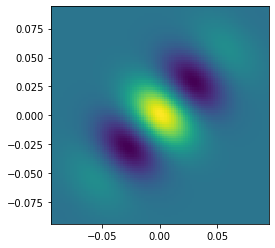

In [2]:
fig,ax = plt.subplots()
#ax = fig.add_subplot(projection='3d')

#ax.imshow(g1, cmap='hot')
#ax.imshow(g1, cmap='hot', extent=extent)
plt.pcolormesh(x,y,g1)
plt.axis('scaled')
plt.show()

# Looks inverted because imshow plots rows down on the "y"

32



/tmp/ipykernel_17589/1507486243.py:75: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[-(i+1), inds[j+k*len(k_temp)]].pcolormesh(x,y,g)


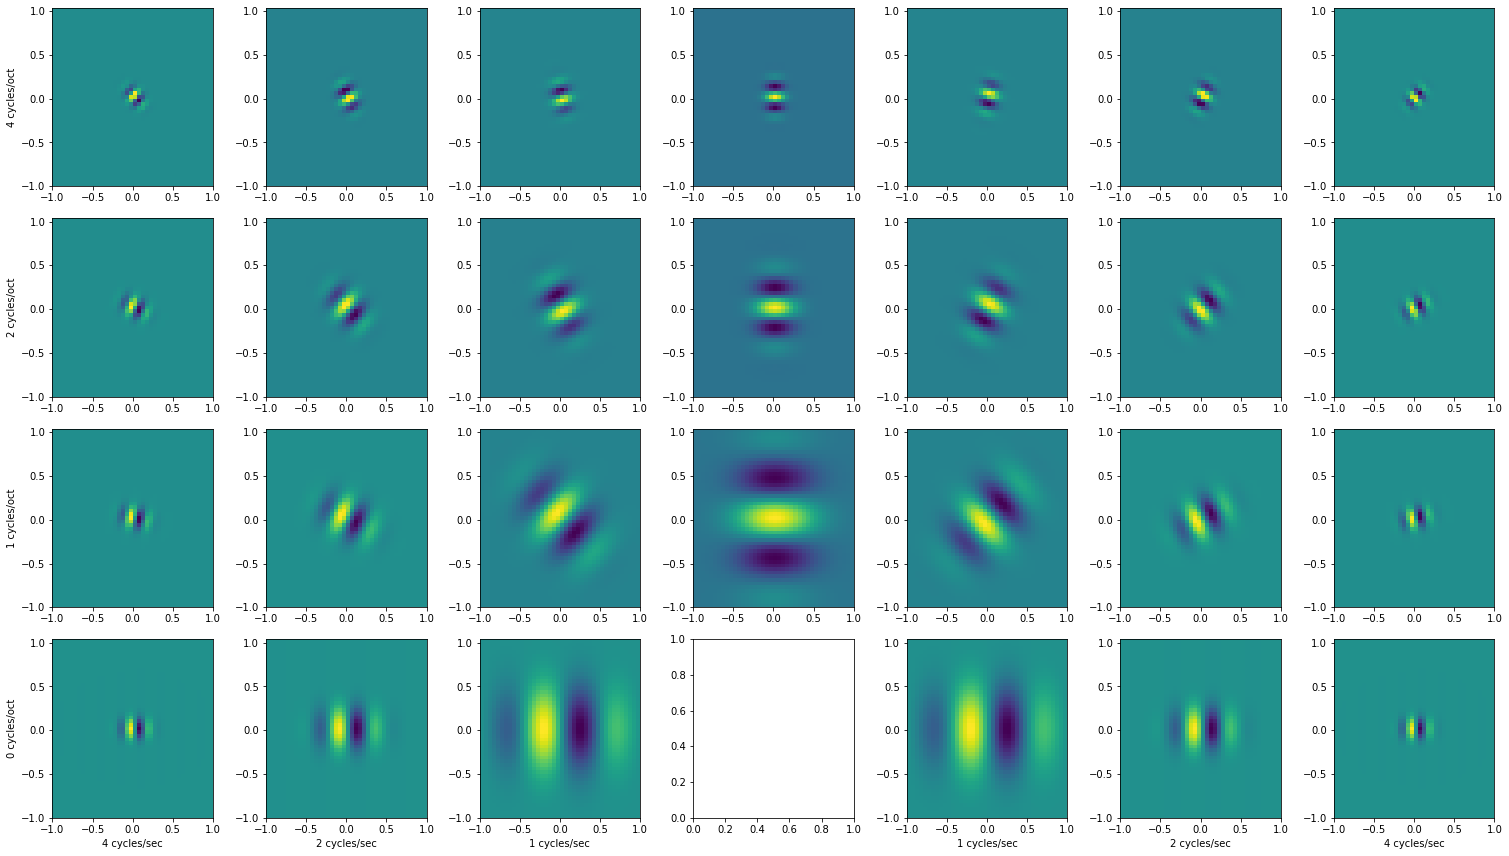

In [79]:
# For 128 Hz, you can't really see the range of spectral, probably because they are all about 90 deg when only up to 8

# Need to run it with display_scaled=False first, then true to get proper figure scaling, then rerun display_scaled=True

display_scaled = False

if display_scaled:
    k_spect = np.array([0, 1, 2, 4, 8])  # cycles/octave
    k_temp = np.array([0, 4, 8, 16, 32, 64, 128])    # Hz
else:
    k_spect = np.array([0, 1, 2, 4])  # cycles/octave
    k_temp = np.array([0, 1, 2, 4])    # Hz

updown = [-1, 1]

max_sig_x = 1/min(k_temp[np.where(k_temp!=0)])*1/2
max_sig_y = 1/min(k_spect[np.where(k_spect!=0)])*1/2

if display_scaled is False:
    nstds = 2  # Number of standard deviation sigma
    xmax = nstds * max_sig_x
    ymax = nstds * max_sig_y
    xmin = -xmax
    ymin = -ymax
    bounds = [xmin, xmax, ymin, ymax]

gamma = 1.5    # Aspect ratio of Gaussian

ks_max = np.max(k_spect)
kt_max = np.max(k_temp)

x_step = min([1/kt_max/5, 1/ks_max*1/2*gamma/2])
y_step = min([1/ks_max/5, 1/kt_max*1/2/gamma/2])      # We can't just satisfy spectral wavelength, we also need to worry about gaussian aspect ratio

nfilts = len(k_spect)*len(k_temp)*len(updown)
print(nfilts)

print()

#fig,ax = plt.subplots(len(k_temp)*len(updown), len(k_spect), figsize=(15,24))
#fig,ax = plt.subplots(len(k_temp)*len(updown), len(k_spect), figsize=(5,10*(ymax-ymin)/(xmax-xmin)))
fig,ax = plt.subplots(len(k_spect), len(k_temp)*len(updown)-1, 
                      figsize=(12*(xmax-xmin)/(ymax-ymin)*(2*len(k_temp)-1)/len(k_spect),12))

# Rewrite sigma in terms of both u0 and v0

inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))

for i,ks in enumerate(k_spect):
    for j,kt in enumerate(k_temp):
        if (kt==0)&(ks==0):
            pass
        else:
            u0 = kt
            v0 = ks
            Lambda = 1/np.linalg.norm([u0,v0])
            sigma = Lambda/2
            if kt != 0:
                psi = np.cos(ks/kt)*np.pi/2
            else:
                psi = 0
                
            for k,ud in enumerate(updown):
                if u0 != 0:
                    theta = np.arctan(v0/u0)*ud
                else: 
                    theta = np.pi/2*ud
                if display_scaled:
                    x_step = Lambda/10
                    y_step = Lambda/10
                    g, x, y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
                else:
                    g, x, y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds)
                
                ax[-(i+1), inds[j+k*len(k_temp)]].pcolormesh(x,y,g)
                
                if (j == len(k_temp)-1) and (k == 0):
                    ax[-(i+1), inds[j+k*len(k_temp)]].set_ylabel('{0} cycles/oct'.format(ks))
                if i == 0:
                    ax[-(i+1), inds[j+k*len(k_temp)]].set_xlabel('{0} cycles/sec'.format(kt))
                #plt.axis('scaled')
                #ax[inds[i+k*len(k_temp)],j+k*len(k_temp)].set_xticks([])
                #ax[inds[i+k*len(k_temp)],j+k*len(k_temp)].set_yticks([])

#fig.supxlabel('Spectral modulation frequency ([0, 0.5, 1, 2, 4, 8] cycles/oct)')
#fig.supylabel('Temporal modulation frequency ([0, 2, 4, 8, 16, 32, 64, 128] Hz)')
fig.tight_layout()

# Looks inverted because imshow plots rows down on the "y"
        
#        for ps in psi:
#            for ud in updown:
#                if ks != 0:
#                    theta = np.arctan(kt/ks)
#                else: 
#                    theta = np.pi/2
#                kt = kt*ps
#                Lambda = 1/np.linalg.norm([kt,ks])
#                g1 = gabor(sigma, theta, Lambda, ps, gamma)
#                ax.imshow(g1, cmap='hot')

plt.show()

        

In [9]:
inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))
inds

array([ 6,  5,  4,  3,  2,  1,  0,  6,  7,  8,  9, 10, 11, 12])

In [10]:
u0 = 128
v0 = 0

if u0 != 0:
    theta = np.arctan(v0/u0)
else: 
    theta = np.pi/2
Lambda = 1/np.linalg.norm([u0,v0])
sigma = 2*Lambda/3

g, x, y = gabor(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')

/tmp/ipykernel_17589/2143284621.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,g)


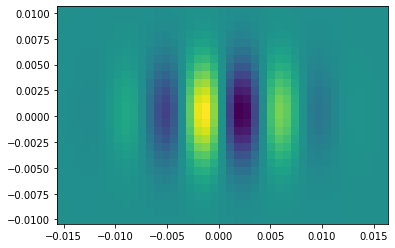

In [11]:
fig,ax = plt.subplots()
plt.pcolormesh(x,y,g)
plt.axis('scaled')
plt.show()


In [16]:
import scipy.io
import numpy as np
#import sounddevice as sd
from IPython.display import Audio
from scipy.io.wavfile import write


here
[0.00000000e+00 3.29638634e-01 6.59277267e-01 ... 7.99934072e+03
 7.99967036e+03 8.00000000e+03]
(24270,)
16000


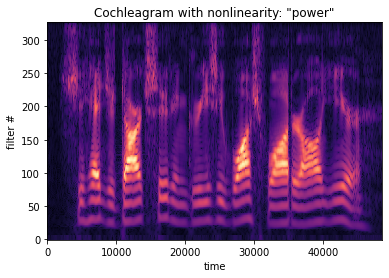

In [15]:
from pycochleagram import cochleagram as cgram
from pycochleagram import erbfilter as erb
from pycochleagram import utils
#from time import time

low_lim = 50 
hi_lim = 20000
# look for "Running demo with sound file: <rfn>
rfn = '/home/ping/pycochleagram/pycochleagram/demo_stim/sa1.wav'
demo_stim, demo_sr = utils.wav_to_array(rfn)
#demo_n = 38  # default filter for low_lim=50 hi_lim=20000
n = int(np.floor(erb.freq2erb(hi_lim) - erb.freq2erb(low_lim)) - 1)
sr = demo_sr
signal = demo_stim
sample_factor = 8    # density of sampling, can be 1,2, or 4
downsample=None

human_coch = cgram.human_cochleagram(signal, sr, n=n, sample_factor=sample_factor,
      downsample=downsample, nonlinearity='power', strict=False)

img = np.flipud(human_coch)  # the cochleagram is upside down (i.e., in image coordinates)

fig,ax = plt.subplots()
ax.set_title('Cochleagram with nonlinearity: "power"')
ax.set_ylabel('filter #')
ax.set_xlabel('time')
utils.cochshow(np.flipud(img), interact=False)
#ax.invert_yaxis()   # Looks upside down, although it matches the demo

print(demo_sr)

In [17]:
padding_size = None
downsample=None
nonlinearity='power'
fft_mode='auto'
ret_mode='envs'
strict=False
erb_kwargs = {}   # confirmed with print
    
#filts, hz_cutoffs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],

filts, center_freqs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],
      sr, n, low_lim, hi_lim, sample_factor, padding_size=padding_size,
      full_filter=True, strict=strict, **erb_kwargs)

/tmp/ipykernel_17589/2614203599.py:11: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  filts, center_freqs, freqs = erb.make_erb_cos_filters_nx(signal.shape[0],


In [18]:
from scipy.interpolate import interp1d 

#log_freqs = np.geomspace(20, 20480, 101)
log_freqs = np.geomspace(40, 10240, 327)
log_freqs = log_freqs[np.where((log_freqs<np.max(center_freqs))&(log_freqs>np.min(center_freqs)))]

n_t = img.shape[1]
Ytf = np.empty((len(log_freqs), n_t))
for i in range(n_t):
    f = interp1d(np.log2(center_freqs), img[:,i], kind='cubic')
    Ytf[:,i] = f(np.log2(log_freqs)) 


In [19]:
#i = 1000
#n_t = img.shape[1]
#Ytf = np.empty((len(log_freqs), n_t))
#log_freqs = log_freqs[np.where((log_freqs<np.max(center_freqs))&(log_freqs>np.min(center_freqs)))]
#f = interp1d(np.log2(center_freqs), img[:,i], kind='cubic', bounds_error=False, fill_value= 'extrapolate')
#fig, ax = plt.subplots(1,2)
#ax[0].plot(np.log2(center_freqs), img[:,i])
#nans = np.where(np.isnan(img))   # appears free of nans
#Ytf[:,i] = f(np.log2(log_freqs)) 
#ax[1].plot(np.log2(log_freqs), Ytf[:,i])



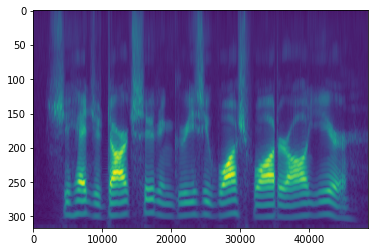

In [20]:
fig, ax = plt.subplots()
ax.imshow(Ytf, aspect='auto')
#utils.cochshow(np.flipud(Ytf), interact=False)

img = Ytf

In [21]:
img.shape
img = img[...,np.newaxis]
img.shape

(317, 48538, 1)

In [23]:
from skimage import data
from skimage.transform import pyramid_gaussian

image = img
rows, cols, dim = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2, channel_axis=None))
#pyramid = tuple(pyramid_gaussian(image, downscale=2, channel_axis=-1))    # For multiple channels, e.g., 3 channel color


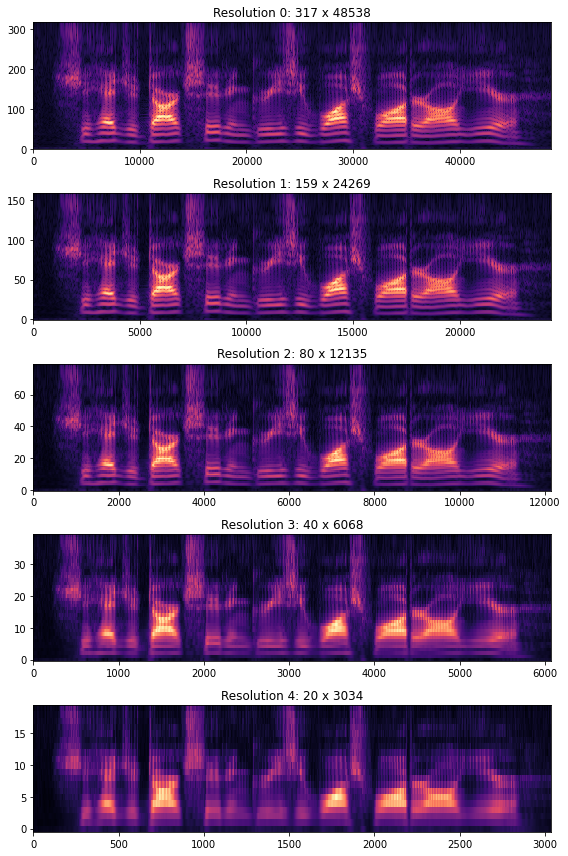

In [24]:
fig, ax = plt.subplots(5,1, figsize=(8,12))

for i in range(5):
    plt.axes(ax[i])
    utils.cochshow(np.flipud(pyramid[i]), interact=False)
    tit_str = 'Resolution {0}: {1} x {2}'.format(i, pyramid[i].shape[0], pyramid[i].shape[1])
    ax[i].set_title(tit_str)
    pyramid[i].shape

fig.tight_layout()


In [25]:
def gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds, scx=1):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    if bounds == 'auto':
        nstds = 2.5  # Number of standard deviation sigma
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        #xmax = abs(nstds*sigma_x*np.cos(theta) + nstds*sigma_y*np.sin(theta))
        #ymax = abs(-nstds*sigma_x*np.sin(theta) + nstds*sigma_y*np.cos(theta))
        #xmax = xmax*scx
        xmin = -xmax
        ymin = -ymax
    elif len(bounds)==4:
        xmin, xmax, ymin, ymax = bounds
    #x_step = x_step/scx
    
    (x, y) = np.meshgrid(np.arange(xmin, xmax + x_step, x_step), np.arange(ymin, ymax + y_step, y_step))
    #x = x/scx
    gauss = np.exp(-.5 * ((x*np.cos(theta) + y*np.sin(theta))**2/sigma_x**2 + (-x*np.sin(theta) + y*np.cos(theta))**2/sigma_y**2))
    wave = np.cos(2*np.pi/Lambda*(x*np.cos(theta)+y*np.sin(theta))+psi)
    gb = gauss * wave

    return gb, x, y

(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)
(14, 26)
(14, 23)
(23, 14)
(26, 14)


/tmp/ipykernel_17589/2550361961.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)
/tmp/ipykernel_17589/2550361961.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)


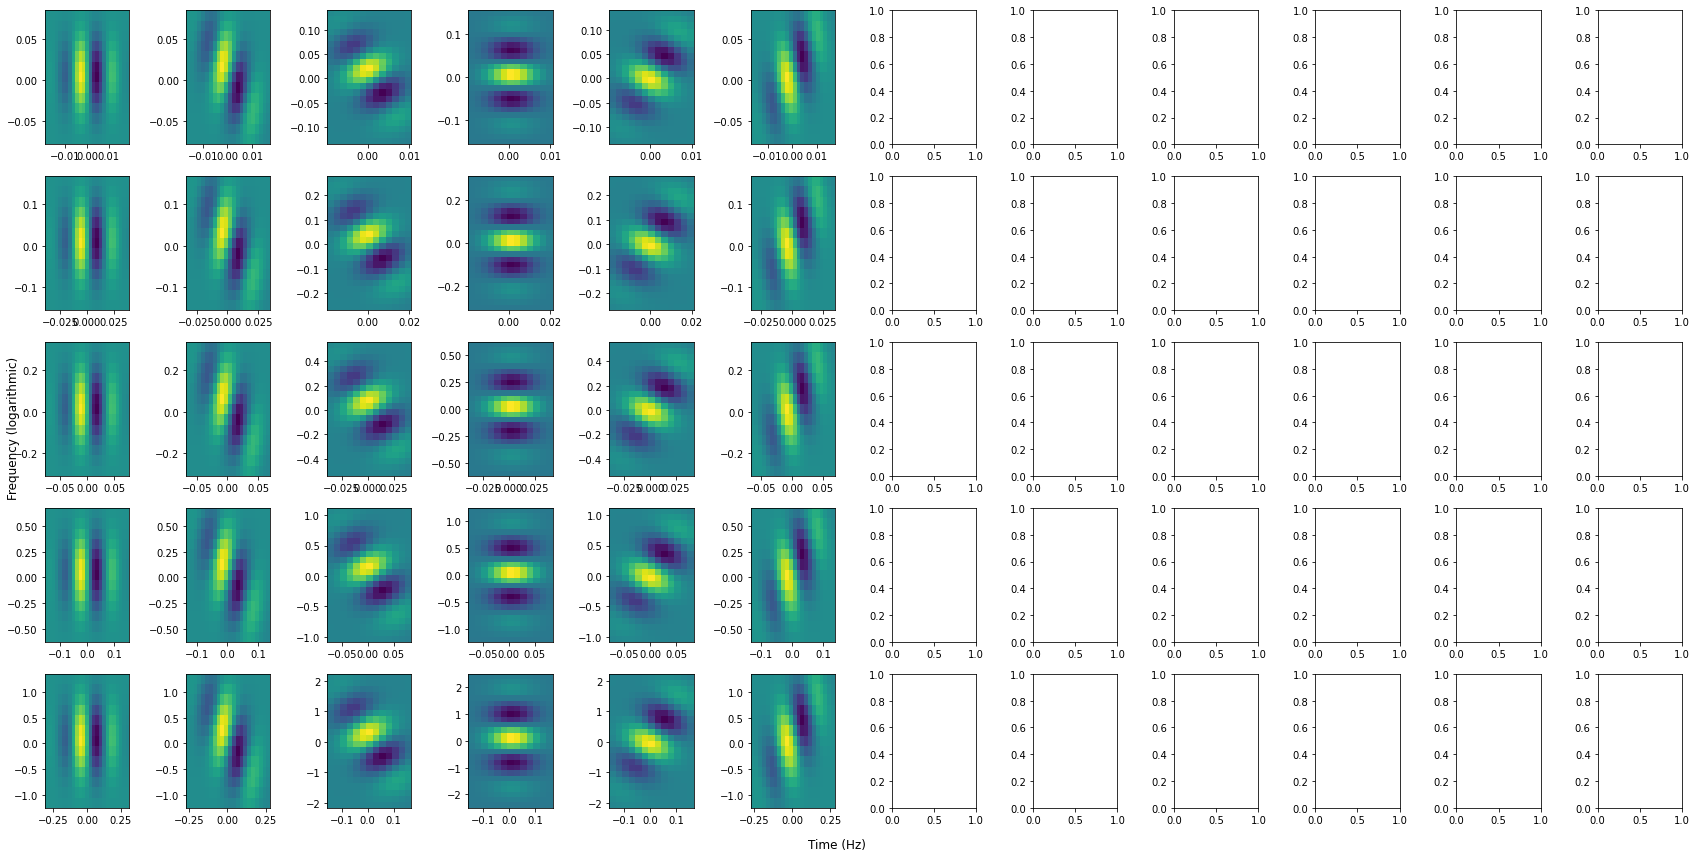

In [26]:
#k_spect = np.array([0.5, 1, 2, 4, 8])  # cycles/octave
#k_temp = np.array([4, 8, 16, 32, 64])    # Hz

# Scale by 8 to arrive at filter? but in normal coordinates?
# 0 appears in each set
# five sets of resolution

# Reflect to get down going
# 7 angles * 5 scales = 35 filters

theta_set = [0, -np.pi/6, -np.pi/3, np.pi/2]
lambda_set = [0.125, 0.25, 0.5, 1, 2]
# Corresponds to spectral freq 8 Hz to 0.5 Hz
# Corresponds to temporal freq 64 Hz to 4 Hz
scx = 8
display_scaled = True

bounds = [-np.max(lambda_set), np.max(lambda_set), -np.max(lambda_set), np.max(lambda_set)]

#gamma_list = [2, 1]    # Aspect ratio of Gaussian
gamma_list = [2]

x_step = min([np.min(lambda_set)/5/scx, np.max(lambda_set)*1/2*gamma/2/scx])
y_step = min([np.min(lambda_set)/5, np.max(lambda_set)*1/2/gamma/2]) 

#x_step = 1/np.min(lambda_set)/8
#y_step = 1/np.min(lambda_set)/8

fig,ax = plt.subplots(len(lambda_set), 2*(len(theta_set)*2-2),  
#                      figsize=(12*(xmax-xmin)/(ymax-ymin)*(2*len(theta_set)-2)*2/len(lambda_set)/scx,12))
                       figsize=(24,12))

# How to store the set of filters - first just plot them
# Rewrite sigma in terms of both u0 and v0 norm

#inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))

all_filts = np.empty((len(lambda_set),len(theta_set)), object)

for i,Lambda in enumerate(lambda_set):
    for j,theta in enumerate(theta_set):
        for k,gamma in enumerate(gamma_list):
            sigma = Lambda/2
            psi = np.cos(theta)*np.pi/2
            if display_scaled:
                x_step = Lambda/10
                y_step = Lambda/10
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
                print(g.shape)
            else:
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, bounds)
            x = x/scx    
            ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)
            all_filts[i,j] = g
            if theta != 0 and theta != np.pi/2:
                g2 = np.flipud(g)
                ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)
        
        #plt.axis('scaled')

fig.supylabel('Frequency (logarithmic)')
fig.supxlabel('Time (Hz)')
fig.tight_layout()


(31, 501)
-0.015625
6.237524950099805e-05
0.000125
(27, 435)
-0.013531646934131855
6.235632183908052e-05
0.000125
(27, 435)
-0.013531646934131853
6.235632183908052e-05
0.000125
(31, 501)
-0.015625
6.237524950099805e-05
0.000125
(31, 501)
-0.03125
0.0001247504990019961
0.00025
(27, 435)
-0.02706329386826371
0.00012471264367816103
0.00025
(27, 435)
-0.027063293868263706
0.00012471264367816103
0.00025
(31, 501)
-0.03125
0.0001247504990019961
0.00025
(31, 501)
-0.0625
0.0002495009980039922
0.0005
(27, 435)
-0.05412658773652742
0.00024942528735632206
0.0005
(27, 435)
-0.05412658773652741
0.00024942528735632206
0.0005
(31, 501)
-0.0625
0.0002495009980039922
0.0005
(31, 501)
-0.125
0.0004990019960079844
0.001
(27, 435)
-0.10825317547305484
0.0004988505747126441
0.001
(27, 435)
-0.10825317547305482
0.0004988505747126441
0.001
(31, 501)
-0.125
0.0004990019960079844
0.001
(31, 501)
-0.25
0.0009980039920159688
0.002
(27, 435)
-0.21650635094610968
0.0009977011494252883
0.002
(27, 435)
-0.216506350

/tmp/ipykernel_17589/2306840011.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)   # ARE THE X,Y Correct for all?
/tmp/ipykernel_17589/2306840011.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)


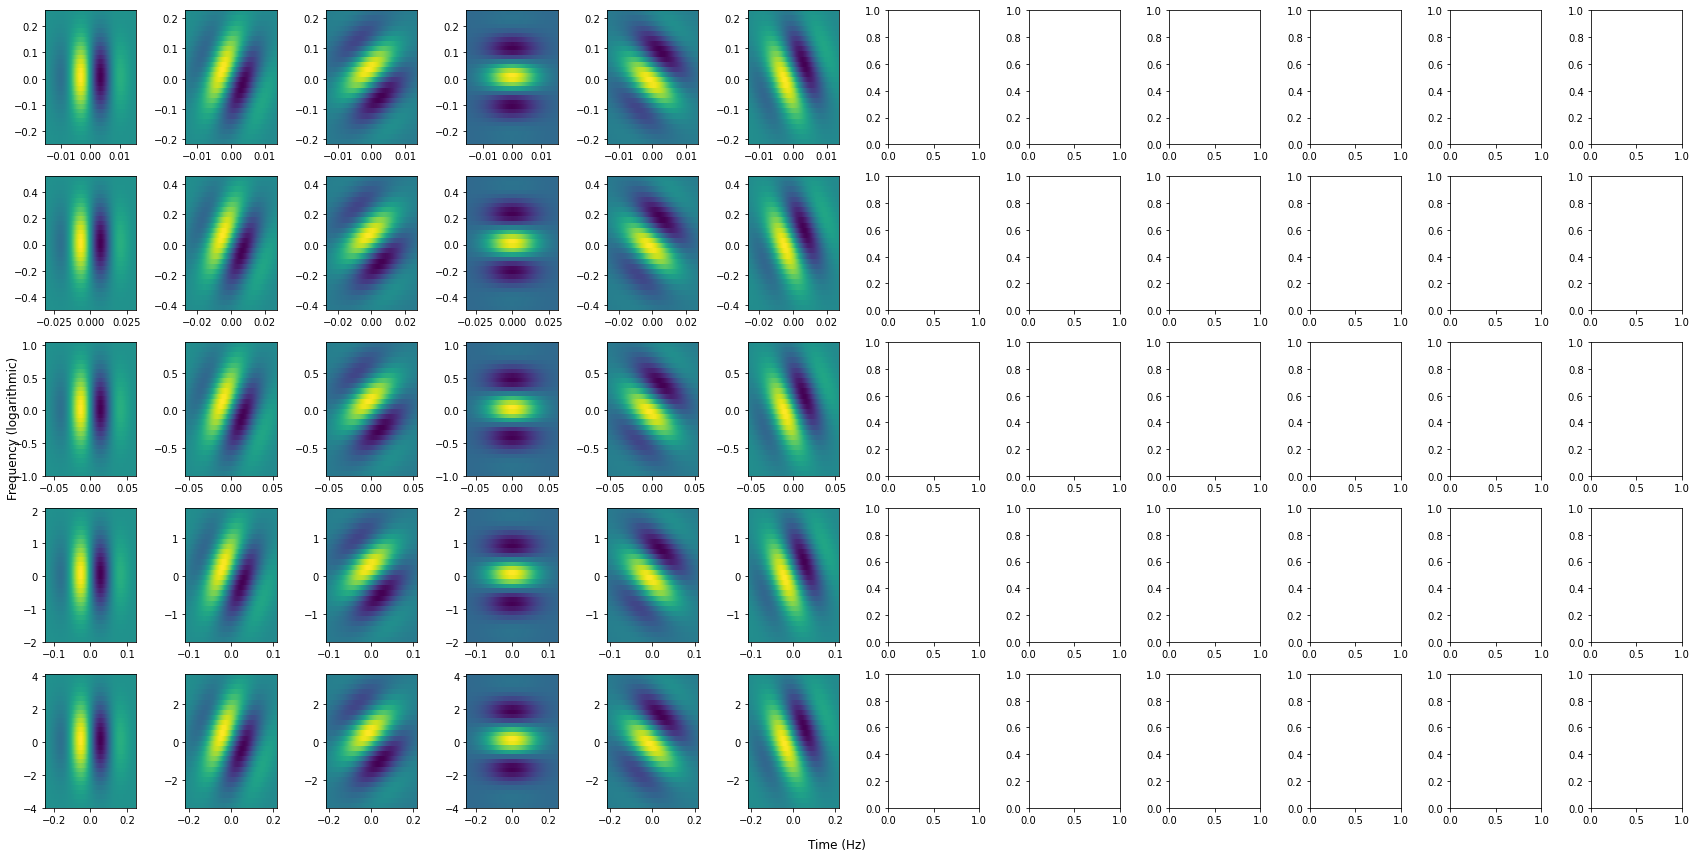

In [27]:
# Resolution matched to cochleagram

#k_spect = np.array([0.5, 1, 2, 4, 8])  # cycles/octave
#k_temp = np.array([4, 8, 16, 32, 64])    # Hz

# Scale by 8 to arrive at filter? but in normal coordinates?
# 0 appears in each set
# five sets of resolution

# Reflect to get down going
# 7 angles * 5 scales = 35 filters

theta_set = [0, -np.pi/6, -np.pi/3, np.pi/2]
#lambda_set = [0.125, 0.25, 0.5, 1, 2]
lambda_set = [0.25, 0.5, 1, 2, 4]

# Corresponds to spectral freq 8 Hz to 0.5 Hz
# Corresponds to temporal freq 64 Hz to 4 Hz
scx = 16   # was 8
display_scaled = True

bounds = [-np.max(lambda_set), np.max(lambda_set), -np.max(lambda_set), np.max(lambda_set)]

#gamma_list = [2, 1]    # Aspect ratio of Gaussian
gamma_list=[1]

y_step_base = np.diff(np.log(log_freqs))[0]
x_step_base = 1/sr*scx

fig,ax = plt.subplots(len(lambda_set), 2*(len(theta_set)*2-2),  
#                      figsize=(12*(xmax-xmin)/(ymax-ymin)*(2*len(theta_set)-2)*2/len(lambda_set)/scx,12))
                       figsize=(24,12))

# How to store the set of filters - first just plot them
# Rewrite sigma in terms of both u0 and v0 norm

#inds = np.concatenate((np.flip(np.arange(len(k_temp))), np.arange(len(k_temp))+len(k_temp)-1))

all_filts = np.empty((len(lambda_set),len(theta_set)*2-2), object)

for i,Lambda in enumerate(lambda_set):
    for j,theta in enumerate(theta_set):
        for k,gamma in enumerate(gamma_list):
            sigma = Lambda/2.5
            psi = np.cos(theta)*np.pi/2
            if display_scaled:
                x_step = x_step_base*(2**i)
                y_step = y_step_base*(2**i)
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step, y_step, 'auto')
                print(g.shape)
            else:
                g, x, y = gabor2(sigma, theta, Lambda, psi, gamma, x_step_base, y_step_base, bounds)
            x = x/scx    
            print(x.min())
            print((x.max()-x.min())/(x.shape[1]))
            print(x_step/8)
            ax[i,j+k*(len(theta_set)*2-2)].pcolormesh(x,y,g)   # ARE THE X,Y Correct for all?
            all_filts[i,j] = g
            if theta != 0 and theta != np.pi/2:
                g2 = np.flipud(g)
                ax[i, 2*len(theta_set)-2-j +k*(len(theta_set)*2-2)].pcolormesh(x,y,g2)
                all_filts[i,2*len(theta_set)-2-j] = g2
        
        #plt.axis('scaled')

fig.supylabel('Frequency (logarithmic)')
fig.supxlabel('Time (Hz)')
fig.tight_layout()



In [28]:
1/16000   # Yes, the resolutions check, final time resolution

6.25e-05

In [30]:
1/16000*2*2*2*2   # final scale has a reasonable time resolution

0.001

(80, 12135, 1)
(110, 12635, 1)


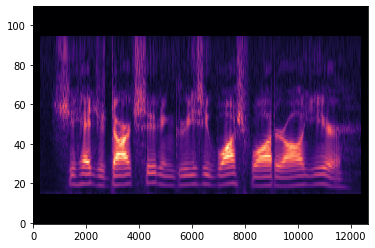

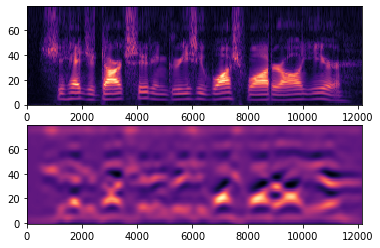

(80, 12135)

In [35]:
#all_filts[0,0].shape
#np.convolve(pyramid[0], all_filts[0,0])
#resp = scipy.signal.convolve(np.squeeze(pyramid[0]),all_filts[0,0], mode='same')
scale = 2
# test out scale = 4
#ifilt = 0
ifilt = 3

# Pads with edge - assumes nothing funky happening at edge of signal

pad_size = all_filts[scale,ifilt].shape[1]-1
#pad_size = 8000 # To visualize
pad_size_bef = int(np.ceil(pad_size/2))
pad_size_aft = pad_size - pad_size_bef

pad_size2 = all_filts[scale,ifilt].shape[0]-1
pad_size_bef2 = int(np.ceil(pad_size2/2))
pad_size_aft2 = pad_size2 - pad_size_bef2

npad = [(0, 0)] * pyramid[scale].ndim
npad[0] = (pad_size_bef2, pad_size_aft2)
npad[1] = (pad_size_bef, pad_size_aft)
#padded_coch = np.pad(pyramid[scale],pad_width=npad, mode='edge')
padded_coch = np.pad(pyramid[scale],pad_width=npad, mode='constant')

utils.cochshow(np.flipud(padded_coch), interact=False)
print(pyramid[scale].shape)
print(padded_coch.shape)

resp = scipy.signal.convolve(np.squeeze(padded_coch),all_filts[scale,ifilt], mode='valid')

# Get edge artifacts if unpadded

resp_norm = resp/resp.max()
y_step = y_step_base*(2**scale)
x_step = x_step_base*(2**scale)/scx
times = np.arange(0,resp_norm.shape[1]*x_step, x_step)
freq_start = np.mean(np.log(log_freqs[0:2**scale]))
freqs = np.exp(np.arange(freq_start,freq_start+y_step*resp_norm.shape[0], y_step))


(x, y) = np.meshgrid(times, freqs)
#(x, y) = np.meshgrid(np.linspace(0, 20000, resp_norm.shape[1]), np.linspace(0, 5000, resp_norm.shape[0]))

fig,ax = plt.subplots(2,1)
plt.sca(ax[0])
utils.cochshow(np.flipud(np.squeeze(pyramid[scale])), interact=False)
#ax[1].pcolormesh(x,y,np.flipud(resp_norm))
#ax[0].pcolormesh(x,y,np.flipud(np.squeeze(pyramid[0])))
# Can we put x and y scales into cochshow? when we do it outside of cochshow, the freq axis is not log and amplitude is prob also not
plt.sca(ax[1])
utils.cochshow(np.flipud(resp_norm), interact=False)
plt.show()

resp_norm.shape

(80, 12135)
(80, 3033)


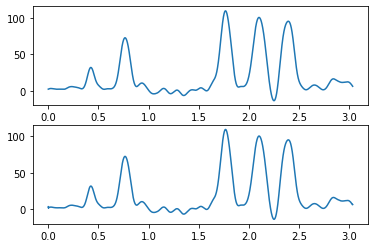

In [36]:
#jfilt = 80-70
jfilt = 80-22
#jfilt = 54 for ifilt 3 scale 0
# Beware flipud when indexing
print(resp.shape)
resp_d, times_d = scipy.signal.resample(resp,int(resp.shape[1]/(2**(4-scale))), t=times, axis=1)
print(resp_d.shape)
fig,ax = plt.subplots(2,1)
ax[0].plot(times,resp[jfilt,:])
ax[1].plot(times_d,resp_d[jfilt,:])
# Should this go through a rectify?

# You shouldn't zero pad in freq either then? artificially creates an edge?

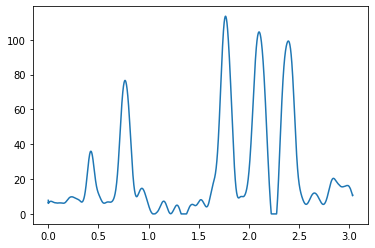

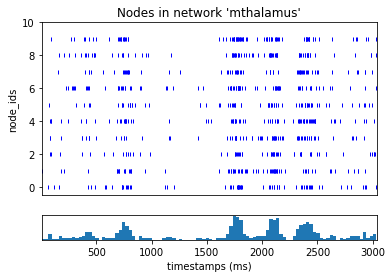

In [37]:
from bmtk.analyzer.spike_trains import plot_raster
from bmtk.builder.networks import NetworkBuilder

thalamus = NetworkBuilder('mthalamus')
thalamus.add_nodes(
    N=10,
    pop_name='tON',
    potential='exc',
    model_type='virtual'
)

thalamus.build()
thalamus.save_nodes(output_dir='/home/ping/Filternet_improvement/network')


def reLU (signal, bendpoint, slope):
    signal_out = np.empty_like(signal)
    signal_out[signal<bendpoint]= 0
    signal_out[signal>=bendpoint]=signal[signal>=bendpoint]-bendpoint
    signal_out[signal_out>=0]*=slope
    return signal_out

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Test ReLU
#signa = np.arange(0,10,0.1)
#output2 = reLU(signa,1,2)
#plt.plot(signa,output2)

# Should we rectify? Yes, see filternet diagram
C = 5
A = 1

input = C+resp_d[jfilt,:]*A
# Rectify
output = reLU(input, 1, 1.0)

#print(output.min())
#print(output.shape)
#print(times.shape)

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator(population='mthalamus')
psg.add(
    node_ids=range(10),  # Have 10 nodes to match mthalamus
    firing_rate=output,    # 10 Hz, we can also pass in a nonhomoegenous function/array
    times=times_d          # 
)

#fn = 
fn = '/home/ping/Filternet_improvement/test_spikes.h5'
psg.to_sonata(fn)

plt.plot(times_d, output)

_ = plot_raster(spikes_file=fn)

In [38]:
times[1]-times[0]

0.00025

In [39]:
times.max()

3.0335

In [40]:
np.median(resp_norm)

0.07059913234075575

In [41]:
print(resp.max())
all_filts[scale,ifilt].max()
padded_coch.max()
scale = 1
ifilt = 0

all_filts[scale,ifilt].shape

109.64199052990347


(31, 501)

In [63]:
from bmtk.utils.reports.spike_trains import SpikeTrains

from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

from matplotlib.ticker import FormatStrFormatter

import matplotlib  # Just for custom tick labels on log axis

def show_filters (cg_pyramid, x_step_base, y_step_base, scale=0, ifilt=0, jfilt=0, scx=1):

    # Pads borders with zeros
    npad = [(0, 0)] * pyramid[scale].ndim

    # Temporal dimension
    a = np.sum(all_filts[scale,ifilt], axis=0)
    start_ind = np.argmax(np.abs(a) > 0.05*np.max(a))
    filt = (all_filts[scale,ifilt][:,start_ind:]).copy()
    # Normalize kernel so sum is 1
    filt /= filt.sum()

    # Just crop the filter
    # Later Also check at least min_latency
    # Show cropped filter
    pad_size = filt.shape[1]-1
    pad_size_bef = pad_size
    pad_size_aft = 0    # This makes it more causal
    #pad_size_bef = int(np.ceil(pad_size/2))
    #pad_size_aft = pad_size - pad_size_bef
    # Spectral dimension
    pad_size2 = filt.shape[0]-1
    pad_size_bef2 = int(np.ceil(pad_size2/2))
    pad_size_aft2 = pad_size2 - pad_size_bef2

    npad[0] = (pad_size_bef2, pad_size_aft2)
    npad[1] = (pad_size_bef, pad_size_aft)
    
    #padded_coch = np.pad(cg_pyramid[scale],pad_width=npad, mode='constant')   # TRY SQUEEZING FIRST
    padded_coch = np.pad(cg_pyramid[scale],pad_width=npad, mode='edge')   # TRY SQUEEZING FIRST
    padded_coch = np.flipud(padded_coch)      # FIX COCHLEAGRAMS UPSIDE DOWN
    # Convolve with filter
    resp = scipy.signal.convolve(np.squeeze(padded_coch), filt, mode='valid')

    resp_norm = resp/resp.max()
    y_step = y_step_base*(2**scale)     
    x_step = x_step_base*(2**scale)/scx
    times = np.arange(0,resp_norm.shape[1]*x_step, x_step)
    freq_start = np.mean(np.log(log_freqs[0:2**scale]))
    freqs = np.exp(np.arange(freq_start,freq_start+y_step*resp_norm.shape[0], y_step))
    print('Latency to peak:', x_step*np.unique(np.argmax(filt,axis=1)))

    (x, y) = np.meshgrid(times, freqs)
    
    fig = plt.figure(constrained_layout=True, figsize=(11,16))
    widths = [resp.shape[1], filt.shape[1]]
    #heights = [filt.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0], resp.shape[0]]
    #specs = fig.add_gridspec(ncols=2, nrows=8, width_ratios=widths, height_ratios=heights)    
    heights = [1,1,1,1,1,1,1]
    specs = fig.add_gridspec(ncols=2, nrows=7, width_ratios=widths, height_ratios=heights)
    
    #fig,ax = plt.subplots(7,1,figsize=(11,16))
       
    ax0 = fig.add_subplot(specs[0,1])
    ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
                   y[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],filt,cmap='magma')
    ax0.set_yscale('log')
    ax0.minorticks_off()
    ax0.set_yticks([y[jfilt-pad_size_bef2,0], y[jfilt+pad_size_aft2+1,0]])
    ax0.set_xticks([0, x[0,filt.shape[1]]])
    print('filt len:',filt.shape[1])
    print(x[0,filt.shape[1]])
    ax0.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax0.set_title('Filter')
    ax0.set_ylim([y[0,0], y[-1,0]])
    ax0.spines["top"].set_visible(False)
    ax0.spines["right"].set_visible(False)
    ax0.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax1 = fig.add_subplot(specs[0,0])
    ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
    ax1.set_yscale('log')
    ax1.set_yticks([100,1000,8000])
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    factor = 2**scale
    ax1.set_title(f'Cochleagram (Downsample factor={factor})')
    xl = ax1.get_xlim()
    ax1.set_ylabel('Frequency (Hz)')
    print(np.squeeze(cg_pyramid[scale]).shape)
    print(x.shape)
    print(y.shape)
    
    ax2 = fig.add_subplot(specs[1,0])
    ax2.pcolormesh(x,y,resp_norm,cmap='magma')
    ax2.set_yscale('log')
    ax2.set_yticks([100,1000,8000])
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_xlim(np.array(xl))
    ax2.set_title(f'Filtered response (Filter #{ifilt})')
    ax2.set_ylabel('Center frequency of filter (Hz)')
 
    resp_d, times_d = scipy.signal.resample(resp,int(resp.shape[1]/(2**(4-scale))), t=times, axis=1)
    
    ax3 = fig.add_subplot(specs[2,0])
    ax3.plot(times,resp[jfilt,:])
    ax3.set_xlim(np.array(xl))
    cfreq = freqs[jfilt]
    ax3.set_title(f'Response of filter centered at {cfreq:.0f} Hz')
        
    ax4 = fig.add_subplot(specs[3,0])
    ax4.plot(times_d,resp_d[jfilt,:])
    ax4.set_xlim(np.array(xl))
    ax4.set_title(f'Response after downsampling to ~1000 Hz')
    
    C = 5    # Be careful variable names not redundant
    A = 30   # Was 20

    input = C+resp_d[jfilt,:]*A
    # Rectify
    output = reLU(input, 1, 1.5)

    psg = PoissonSpikeGenerator(population='mthalamus')
    psg.add(
        node_ids=range(10),  # Have 10 nodes to match mthalamus
        firing_rate=output,    # 10 Hz, we can also pass in a nonhomoegenous function/array
        times=times_d          # 
    )

    fn = '/home/ping/Filternet_improvement/test_spikes.h5'
    psg.to_sonata(fn)

    ax5 = fig.add_subplot(specs[4,0])
    ax5.plot(times_d, output)
    ax5.set_xlim(np.array(xl))
    ax5.set_title(f'Response after ReLU rectification')
    ax5.set_ylabel('Firing rate (spk/s)')
    #plt.sca(ax[5])
    
    spikes = SpikeTrains.load(fn)
    spikes_df = spikes.to_dataframe(population='virt_exc')
    
    ax6 = fig.add_subplot(specs[5,0])
    for n in range(10):
        spktimes = spikes_df[spikes_df['node_ids']==n]['timestamps']
        ax6.scatter(spktimes, n*np.ones(len(spktimes)), marker='|', c='blue')
    ax6.set_xlim(np.array(xl)*1000)
    ax6.set_title(f'Simulated response spike trains')

    ax7 = fig.add_subplot(specs[6,0])
    ax7.hist(spikes_df['timestamps'], bins=np.arange(0,xl[1]*1000,10))
    ax7.set_xlim(np.array(xl)*1000)
    ax7.set_title(f'Simulated response histogram')
    ax7.set_xlabel('Time (s)')
    
    #bbox = ax[0].get_window_extent()
    
    #fig.tight_layout()
    plt.show()
    
    #fig = plot_raster(spikes_file=fn, times=(times_d.min()*1000,times_d.max()*1000))
    #ax_list = fig.axes
    #ax_list[0].set_xlim([times[0],times[1]])
    #ax_list[1].set_xlim([times[0],times[1]])

In [43]:
# Beware default cartesian indexing on meshgrid (not i,j)
(x, y) = np.meshgrid(times, freqs)
print(len(times))
print(len(freqs))
print(x.shape)

12135
80
(80, 12135)


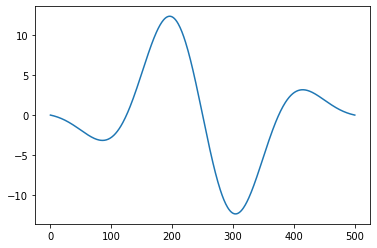

In [44]:
# If we don't copy when assigning to filt, it gets bound / referenced and gets modified on repeat run
d = np.sum(all_filts[scale,ifilt], axis=0)
plt.plot(d)

Latency to peak: [0.043]
filt len: 477
0.11925000000000001
(80, 12135)
(80, 12135)
(80, 12135)


/tmp/ipykernel_17589/778356252.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_17589/778356252.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_17589/778356252.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated sinc

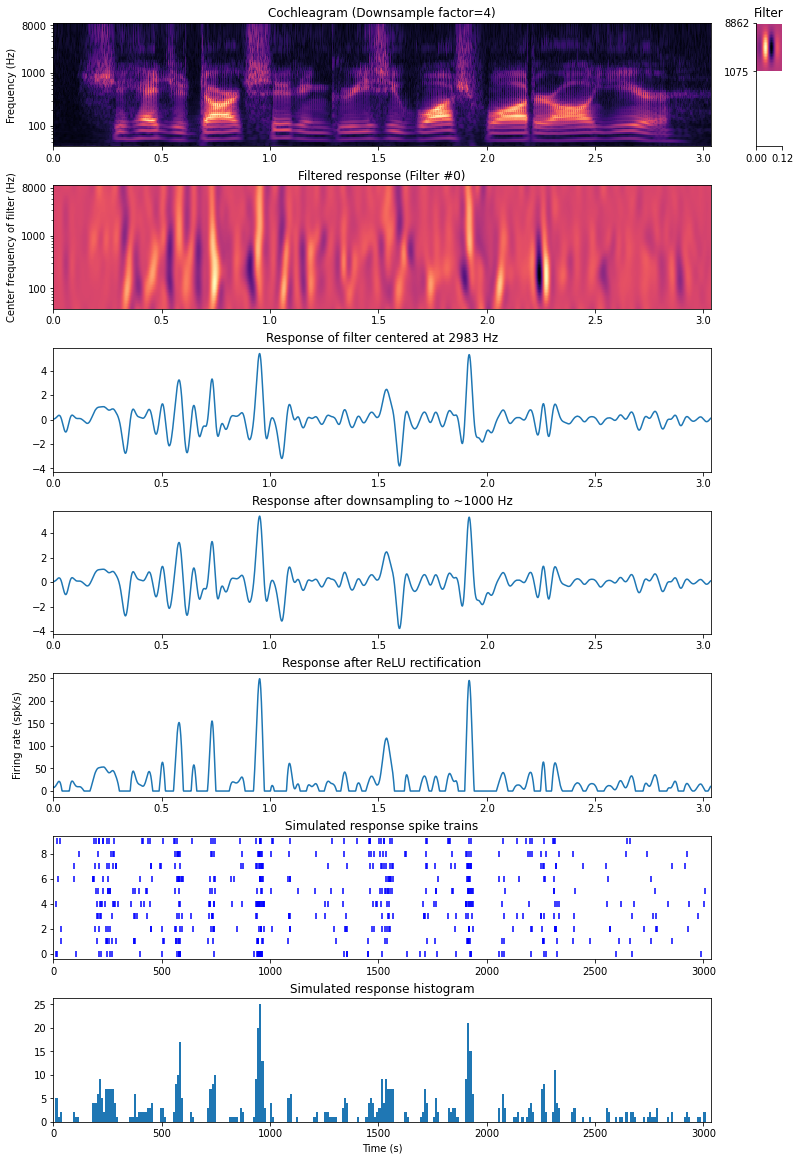

In [64]:
# Because padding is not plotted, do not choose a filter that extends past the edge
show_filters(pyramid, x_step_base, y_step_base, scale=2, ifilt=0, jfilt=63, scx=16)

In [46]:
0.06/(1/16000)

960.0

Latency to peak: [0.01525  0.030875]
filt len: 495
0.0309375


/tmp/ipykernel_17589/778356252.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_17589/778356252.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')


(317, 48538)
(317, 48538)
(317, 48538)


/tmp/ipykernel_17589/778356252.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(x,y,resp_norm,cmap='magma')


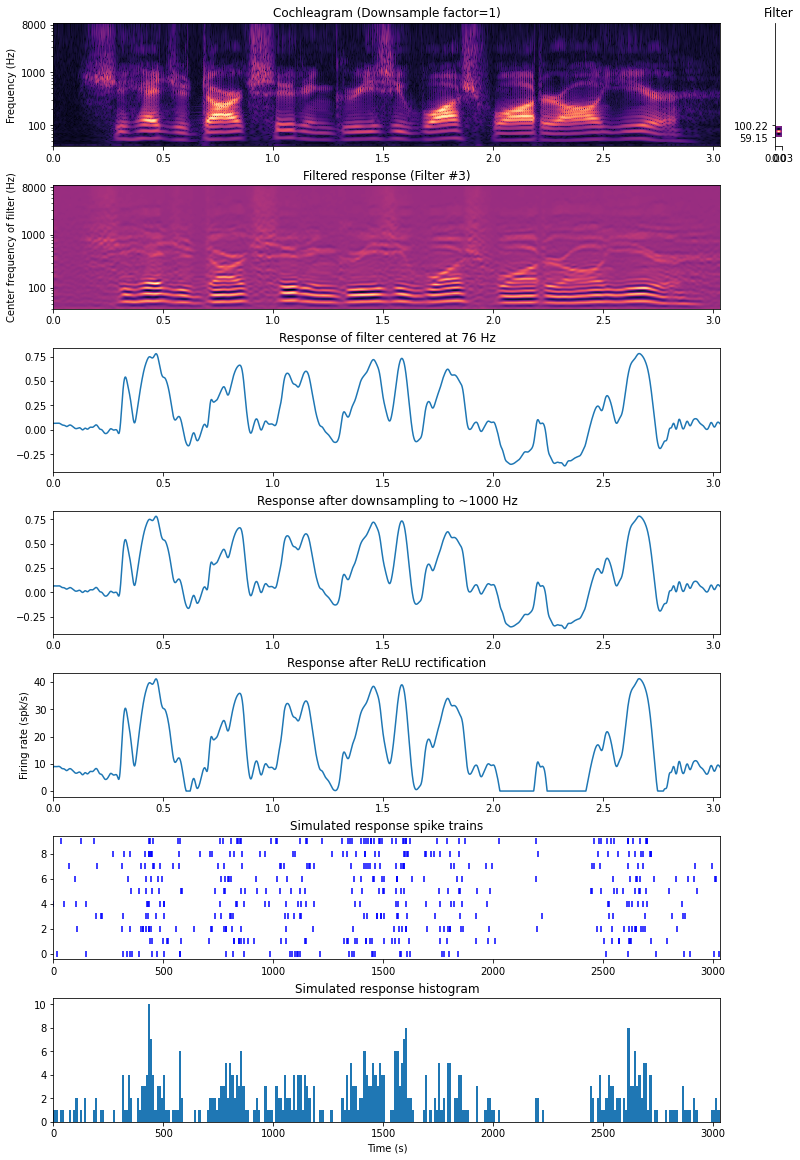

In [73]:
show_filters(pyramid, x_step_base, y_step_base, scale=0, ifilt=3, jfilt=38, scx=16)

Latency to peak: [0.007  0.0075 0.0185 0.019  0.03   0.0405 0.0505 0.0605 0.07   0.079
 0.088  0.097  0.106  0.1065 0.1155 0.116  0.1255 0.126  0.136  0.1465
 0.147  0.158  0.1585 0.1695 0.17  ]
filt len: 392
0.196
(80, 12135)
(80, 12135)
(80, 12135)


/tmp/ipykernel_17589/778356252.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_17589/778356252.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')
/tmp/ipykernel_17589/778356252.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated sinc

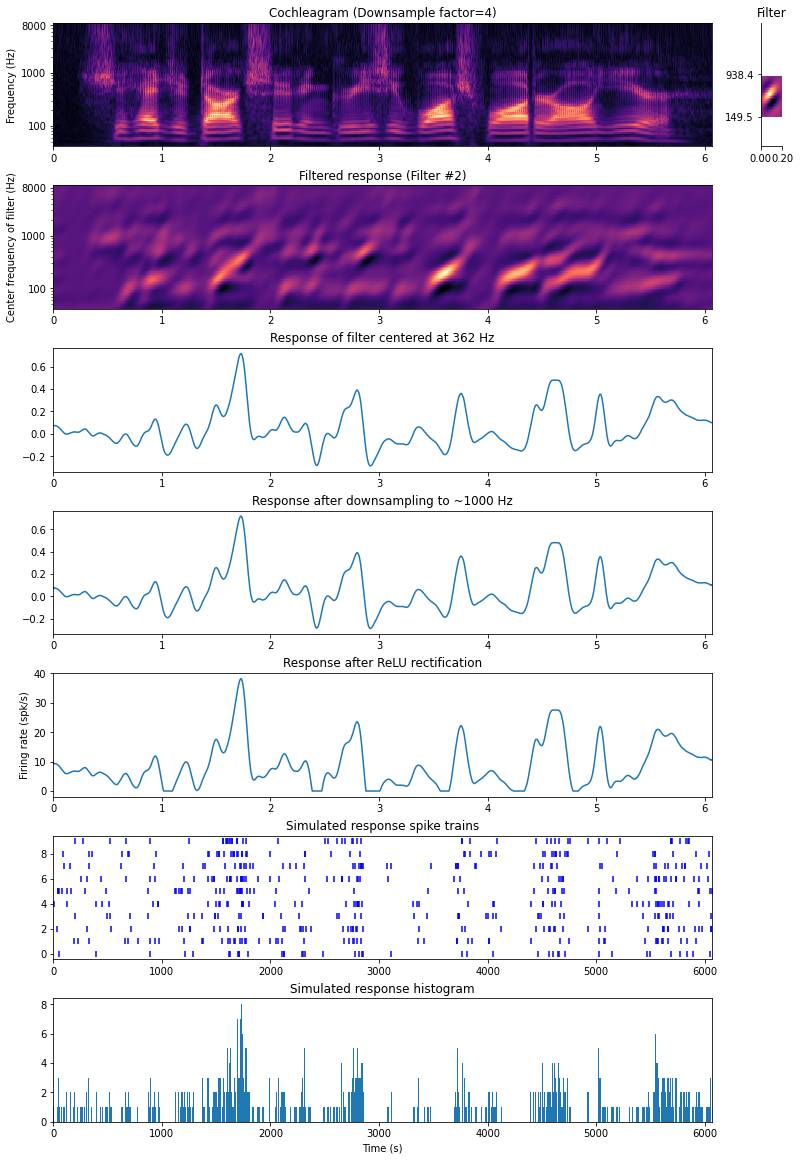

In [74]:
show_filters(pyramid, x_step_base, y_step_base, scale=2, ifilt=2, jfilt=32, scx=8)

# For rising filter why doesn’t convolution flip the filter? 
# Actually flipped twice – left right, then up down

Latency to peak: [0.01075]
filt len: 477
0.029812500000000002


/tmp/ipykernel_17589/778356252.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolormesh(x[jfilt-pad_size_bef2:jfilt+pad_size_aft2+1,:filt.shape[1]],
/tmp/ipykernel_17589/778356252.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(x,y,np.flipud(np.squeeze(cg_pyramid[scale])),cmap='magma')


(317, 48538)
(317, 48538)
(317, 48538)


/tmp/ipykernel_17589/778356252.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(x,y,resp_norm,cmap='magma')


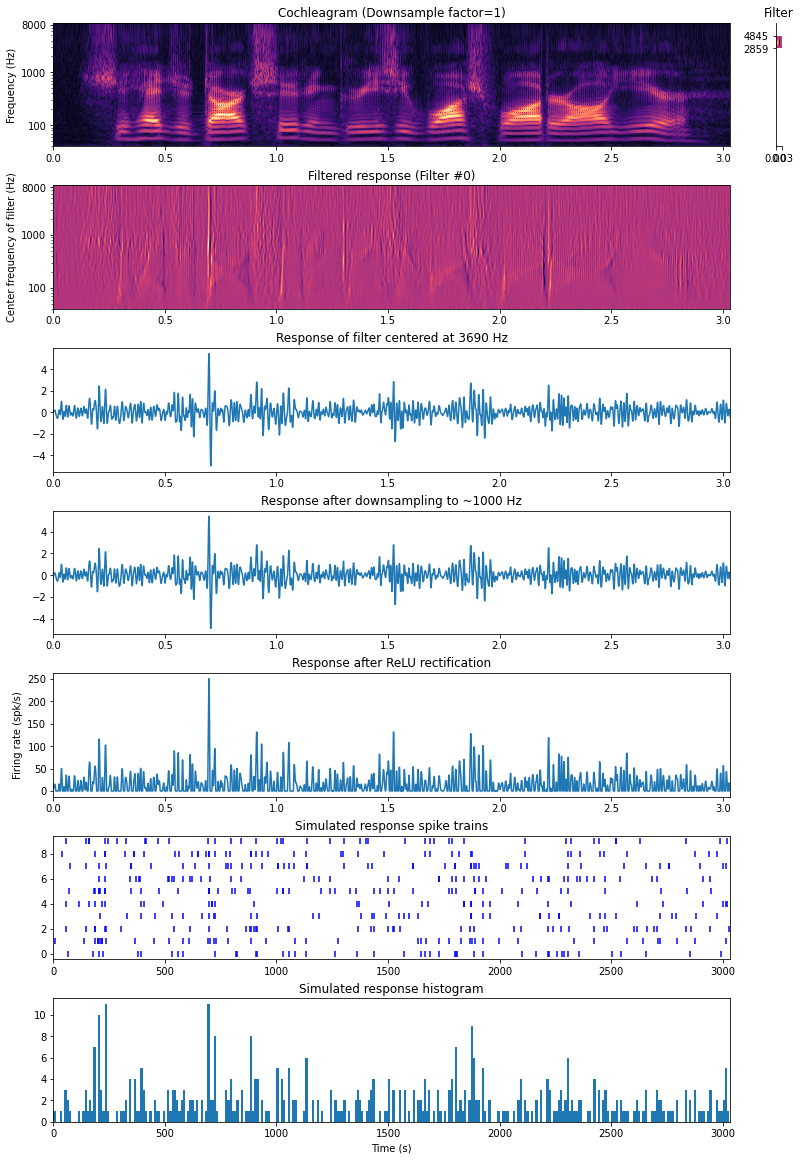

In [75]:
# To get minimal latency

show_filters(pyramid, x_step_base, y_step_base, scale=0, ifilt=0, jfilt=266, scx=16)

In [131]:
xl = (-0.09083747936158504, 1.907587066593286)
list(xl)
ax.set_xlim(np.array(xl)*1000)
#ax.set_xlim([0,1.75])

(-90.83747936158504, 1907.587066593286)

In [25]:
np.log(log_freqs)

array([3.68887945, 3.7058892 , 3.72289895, 3.73990869, 3.75691844,
       3.77392819, 3.79093793, 3.80794768, 3.82495743, 3.84196717,
       3.85897692, 3.87598667, 3.89299642, 3.91000616, 3.92701591,
       3.94402566, 3.9610354 , 3.97804515, 3.9950549 , 4.01206464,
       4.02907439, 4.04608414, 4.06309388, 4.08010363, 4.09711338,
       4.11412312, 4.13113287, 4.14814262, 4.16515236, 4.18216211,
       4.19917186, 4.2161816 , 4.23319135, 4.2502011 , 4.26721084,
       4.28422059, 4.30123034, 4.31824008, 4.33524983, 4.35225958,
       4.36926932, 4.38627907, 4.40328882, 4.42029856, 4.43730831,
       4.45431806, 4.47132781, 4.48833755, 4.5053473 , 4.52235705,
       4.53936679, 4.55637654, 4.57338629, 4.59039603, 4.60740578,
       4.62441553, 4.64142527, 4.65843502, 4.67544477, 4.69245451,
       4.70946426, 4.72647401, 4.74348375, 4.7604935 , 4.77750325,
       4.79451299, 4.81152274, 4.82853249, 4.84554223, 4.86255198,
       4.87956173, 4.89657147, 4.91358122, 4.93059097, 4.94760

In [76]:
freqs = np.array([(a + b) / 2 for a, b in zip(log_freqs[::2], log_freqs[1::2])])
freqs.shape
freqs2 = np.array([(a + b) / 2 for a, b in zip(freqs[::2], freqs[1::2])])

print(np.log(freqs[1])-np.log(freqs[0]))
scale = 1
y_sr = y_SR_base*(2**scale)
y_sr
print(y_sr)

freqs2.shape
freqs2

0.03401949352441447


NameError: name 'y_SR_base' is not defined

In [77]:
scale = 2
freq_start = np.mean(np.log(log_freqs[0:2**scale]))
freqs = np.exp(np.arange(freq_start,freq_start+y_sr*(resp_norm.shape[0]), y_sr))
freqs = freqs[:resp_norm.shape[0]]
print(freqs.shape)
freqs

NameError: name 'y_sr' is not defined

In [78]:
log_freqs
#log_freqs.shape

array([  40.        ,   40.68620945,   41.38419098,   42.09414656,
         42.81628159,   43.55080501,   44.29792936,   45.05787081,
         45.83084922,   46.61708827,   47.41681543,   48.2302621 ,
         49.05766364,   49.89925945,   50.75529304,   51.62601208,
         52.51166851,   53.41251859,   54.32882297,   55.26084676,
         56.20885964,   57.17313591,   58.15395456,   59.15159939,
         60.16635905,   61.19852716,   62.24840235,   63.3162884 ,
         64.40249428,   65.50733429,   66.63112808,   67.77420083,
         68.93688325,   70.11951177,   71.32242856,   72.54598167,
         73.79052513,   75.05641902,   76.34402962,   77.65372948,
         78.98589756,   80.34091929,   81.71918674,   83.1210987 ,
         84.54706078,   85.99748558,   87.47279276,   88.97340919,
         90.49976904,   92.05231396,   93.63149316,   95.23776354,
         96.87158987,   98.53344488,  100.22380941,  101.94317254,
        103.69203175,  105.47089305,  107.28027113,  109.12068